# AL : AI Merger of Photos with Art 
## Neural Style Transfer Model
## Art of a Scientist 2021


Inspired by Tensorflow tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer 

and Datacamp tutorial: https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow


***

### Set pathway to content image and style image:

In [1]:
content_path = str('trainA/12.arches-national-park-overlook-1400x500.jpg')
style_path = str('trainB/brinnaebent_art.jpg')
keyname = str('imagex')

### Import libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['figure.figsize'] = (24,24)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

C:\Users\Brinnae\Anaconda3_1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Brinnae\Anaconda3_1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Brinnae\Anaconda3_1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Brinnae\Anaconda3_1\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

## Set functions 
Adopted from Tensorflow tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer
***

### Converts tensor to numpy array then to a PIL image to save
PIL images: https://auth0.com/blog/image-processing-in-python-with-pillow/

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

### Loads Image- 
Converts to tf image, Resizes image 

**(this is where the resolution gets set for the final output)**

In [4]:
def load_img(path_to_img):
    max_dim = 512             #Set to 512 when initially running. For high resolution photos for printing purposes, set to 1200+
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

### Load pre-trained VGG-

VGG19 is a CNN tensorflow model, trained on imagenet data (more than 1 million images)

More about VGG19: https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4

VGG19 Tensorflow Implementation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19

IMAGENET data: http://www.image-net.org/

In [5]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

### Calculate Gram matrix for style- 

The style of an image can be described by the means and correlations across the different feature maps. 

Gram matrix takes the outer product of the feature vector with itself at each location, and averages that outer product over all locations.

More here on how to implement this in tensorflow: https://www.tensorflow.org/api_docs/python/tf/einsum

In [6]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Keeps pixel values between 0 and 1-

In [7]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### Define Loss-
Total loss is a weighted combination of style and loss

Optimizes based on this weighted combination

In [8]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

### Build and Run Model-

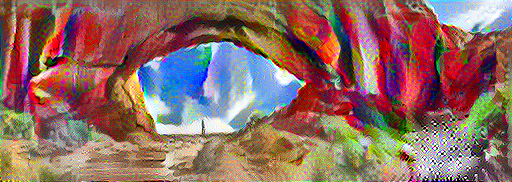

Train step: 1000
Total time: 2003.0


In [9]:
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    
    #Intermediate layers from the network to represent the style and content of the image:
    # Content layer where will pull our feature maps
    content_layers = ['block5_conv2'] 

    # Style layer of interest
    style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    #Creates model:
    style_extractor = vgg_layers(style_layers)
    style_outputs = style_extractor(style_image*255)
    
    #Model that returns style and content tensors:
    
    class StyleContentModel(tf.keras.models.Model):
        def __init__(self, style_layers, content_layers):
            super(StyleContentModel, self).__init__()
            self.vgg =  vgg_layers(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)
            self.vgg.trainable = False

        def call(self, inputs):
            inputs = inputs*255.0
            preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
            outputs = self.vgg(preprocessed_input)
            style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

            style_outputs = [gram_matrix(style_output)
                for style_output in style_outputs]

            content_dict = {content_name:value 
                for content_name, value 
                in zip(self.content_layers, content_outputs)}

            style_dict = {style_name:value
                for style_name, value
                in zip(self.style_layers, style_outputs)}

            return {'content':content_dict, 'style':style_dict}

    extractor = StyleContentModel(style_layers, content_layers)

    results = extractor(tf.constant(content_image))

    style_results = results['style']
    
    #Gradient Descent
    
    #Target values for content and style:
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    
    #Initialize image to optimize
    image = tf.Variable(content_image)
    
    #Optimizer (here we use Adam):
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    
    #Weighted combination of two lossess for total loss:
    style_weight=1e-2
    content_weight=1e4
    
    #Update image:
    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    import time
    start = time.time()    
    
    epochs = 10
    steps_per_epoch = 100  #Change this to change amount of convergence - Typically toggle between 10 (lower style integration) and 100 (Higher style integration)

    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))
        file_name = (keyname + '_iteration' + str(step) + '.jpg')
        tensor_to_image(image).save(file_name, quality=100, subsampling=0)

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

### This code runs a small Audio clip to let you know that the code has run:

In [10]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

***
***

## Appendix

**ML Art Resources:**

Interview with Memo Akten: https://www.artnome.com/news/2018/12/13/machine-learning-art-an-interview-with-memo-akten 

Wired article: https://www.wired.com/story/we-made-artificial-intelligence-art-so-can-you/

Robbie Barrat GitHub: https://github.com/robbiebarrat?tab=repositories

Googlenet caffe: https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet

CNN Places Scene recognition: http://places.csail.mit.edu/downloadCNN.html

Duke AI for Art 2018/19: https://today.duke.edu/2019/03/these-works-art-were-created-artificial-intelligence

Cyclegan forest abstract art: https://github.com/zachmonge/cyclegan_forest_abstract_art_Duke_zm/blob/master/cyclegan_forest_abstract_art_Duke_zm.ipynb

GAN modeling: https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

CatDCGAN: https://github.com/simoninithomas/CatDCGAN/blob/master/Cat%20DCGAN.ipynb

Cyclegan tutorial: https://www.tensorflow.org/tutorials/generative/cyclegan

Interview with Helena Sarin, artist: https://www.artnome.com/news/2018/11/14/helena-sarin-why-bigger-isnt-always-better-with-gans-and-ai-art

Cyclegan GitHub: https://github.com/tensorflow/gan/tree/master/tensorflow_gan/examples/cyclegan

Article on Art ML models (+ Neural transfer!): https://thegradient.pub/playing-a-game-of-ganstruction/

Neural Style transfer tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer

Medium article on Neural transfer style and eager execution: https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

Load images tensorflow: https://www.tensorflow.org/tutorials/load_data/images

Neural Transfer tutorial (Datacamp): https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow